In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from ConditionalModels import ConditionalUNet, ConditionalDiffusionModel
# from train_utils import train, evaluate

In [9]:
def train(diffusion_model, dataloader, optimizer, scheduler=None, num_epoch=1, verbose=False, print_steps=100):
    progress_bar = tqdm(range(num_epoch*len(dataloader)))
    device = next(diffusion_model.parameters()).device
    for epoch in range(num_epoch):
        training_loss = 0
        sample_cnt = 0
        diffusion_model.train()
        for step, (images, labels) in enumerate(dataloader):
            x_0 = images.to(device)
            loss = diffusion_model(x_0, labels.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            progress_bar.update(1)

            bs = x_0.shape[0]
            sample_cnt += bs
            training_loss += loss.detach().cpu() * bs

            if verbose and step % print_steps == print_steps-1:
                # print training loss
                training_loss /= sample_cnt
                sample_cnt = 0
                print('step:', step+1, ' training loss={:.4f}'.format(training_loss))


def evaluate(diffusion_model, dataloader, verbose=True):
    progress_bar = tqdm(range(len(dataloader)))
    device = next(diffusion_model.parameters()).device
    diffusion_model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in dataloader:
            x_0 = images.to(device)
            loss = diffusion_model(x_0, labels.to(device))
            bs = images.shape[0]
            test_loss += bs*loss
            progress_bar.update(1)

        test_loss /= len(dataloader.dataset)
        if verbose:
            print('eval loss={:.4f}'.format(test_loss))

    return test_loss

In [2]:
config = {
    "epoch": 100,
    "batch_size": 128,
    "lr": 1e-4,
    "betas": (0.9,0.99),
    "weight_decay": 0,
    "T": 1000,
    "num_labels": 10,
    "input_ch": 3,
    "channel": 128,
    "channel_mult": [1,2,3,4],
    "attn": [1],
    "num_res_blocks": 2,
    "dropout": 0.1,
    "beta_range": (1e-4, 0.02),
    "device": "cuda:0",
}

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_train = torchvision.datasets.CIFAR10(
    root="./data/",
    train=True,
    download=True,
    transform=transform,
)

cifar10_eval = torchvision.datasets.CIFAR10(
    root="./data/",
    train=False,
    download=True,
    transform=transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device(config["device"])
print("device:",device)
model = ConditionalUNet(
    T=config["T"], num_labels=config["num_labels"], input_ch=config["input_ch"], ch=config["channel"], ch_mult=config["channel_mult"],
    num_res_blocks=config["num_res_blocks"], dropout=config["dropout"]).to(device)

device: cuda:0


In [5]:
diffusion_model = ConditionalDiffusionModel(model=model,beta_range=config["beta_range"],T=config["T"]).to(device)
print("number of parameters: ",sum(p.numel() for p in diffusion_model.parameters()))

number of parameters:  105827203


In [6]:
optimizer = torch.optim.Adam(diffusion_model.parameters(),lr=config["lr"],betas=config["betas"],weight_decay=config["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=config["epoch"])

In [7]:
train_dataloader = DataLoader(cifar10_train, batch_size=config["batch_size"], shuffle=True,)
eval_dataloader = DataLoader(cifar10_eval, batch_size=config["batch_size"])

In [10]:
min_loss = 0.04

for epoch in range(config["epoch"]):
    print("epoch:",epoch+1)
    train(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,verbose=True)
    eval_loss = evaluate(diffusion_model=diffusion_model, dataloader=eval_dataloader)

    if eval_loss < min_loss:
        print("saving model in epoch", epoch+1)
        file_name = "./checkpoints/Conditional_cifar10_epoch"+str(epoch+1)+".pth"
        torch.save(diffusion_model.state_dict(), file_name)
        print("saved to ", file_name)
        min_loss = eval_loss

epoch: 1


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.1576
step: 200  training loss=0.0857
step: 300  training loss=0.0595


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0491
epoch: 2


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0507
step: 200  training loss=0.0459
step: 300  training loss=0.0442


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0397
saving model in epoch 2
saved to  ./checkpoints/Conditional_cifar10_epoch2.pth
epoch: 3


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0419
step: 200  training loss=0.0418
step: 300  training loss=0.0418


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0378
saving model in epoch 3
saved to  ./checkpoints/Conditional_cifar10_epoch3.pth
epoch: 4


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0394
step: 200  training loss=0.0380
step: 300  training loss=0.0400


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0348
saving model in epoch 4
saved to  ./checkpoints/Conditional_cifar10_epoch4.pth
epoch: 5


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0385
step: 200  training loss=0.0361
step: 300  training loss=0.0372


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0350
epoch: 6


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0371
step: 200  training loss=0.0358
step: 300  training loss=0.0365


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0333
saving model in epoch 6
saved to  ./checkpoints/Conditional_cifar10_epoch6.pth
epoch: 7


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0351
step: 200  training loss=0.0351
step: 300  training loss=0.0351


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0331
saving model in epoch 7
saved to  ./checkpoints/Conditional_cifar10_epoch7.pth
epoch: 8


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0350
step: 200  training loss=0.0339
step: 300  training loss=0.0347


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0327
saving model in epoch 8
saved to  ./checkpoints/Conditional_cifar10_epoch8.pth
epoch: 9


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0336
step: 200  training loss=0.0353
step: 300  training loss=0.0336


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0327
saving model in epoch 9
saved to  ./checkpoints/Conditional_cifar10_epoch9.pth
epoch: 10


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0349
step: 200  training loss=0.0338
step: 300  training loss=0.0329


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0331
epoch: 11


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0342
step: 200  training loss=0.0334
step: 300  training loss=0.0329


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0327
epoch: 12


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0333
step: 200  training loss=0.0345
step: 300  training loss=0.0324


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0315
saving model in epoch 12
saved to  ./checkpoints/Conditional_cifar10_epoch12.pth
epoch: 13


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0320
step: 200  training loss=0.0339
step: 300  training loss=0.0325


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0337
epoch: 14


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0326
step: 200  training loss=0.0331
step: 300  training loss=0.0328


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0315
saving model in epoch 14
saved to  ./checkpoints/Conditional_cifar10_epoch14.pth
epoch: 15


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0329
step: 200  training loss=0.0329
step: 300  training loss=0.0328


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0315
saving model in epoch 15
saved to  ./checkpoints/Conditional_cifar10_epoch15.pth
epoch: 16


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0320
step: 200  training loss=0.0320
step: 300  training loss=0.0327


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0324
epoch: 17


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0325
step: 200  training loss=0.0329
step: 300  training loss=0.0327


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0331
epoch: 18


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0335
step: 200  training loss=0.0336
step: 300  training loss=0.0340


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0330
epoch: 19


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0315
step: 200  training loss=0.0325
step: 300  training loss=0.0314


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0322
epoch: 20


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0316
step: 200  training loss=0.0324
step: 300  training loss=0.0323


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0327
epoch: 21


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0314
step: 200  training loss=0.0323
step: 300  training loss=0.0313


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0319
epoch: 22


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0314
step: 200  training loss=0.0333
step: 300  training loss=0.0316


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0310
saving model in epoch 22
saved to  ./checkpoints/Conditional_cifar10_epoch22.pth
epoch: 23


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0307
step: 200  training loss=0.0315
step: 300  training loss=0.0320


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0320
epoch: 24


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0314
step: 200  training loss=0.0316
step: 300  training loss=0.0317


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0323
epoch: 25


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0324
step: 200  training loss=0.0316
step: 300  training loss=0.0314


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0310
saving model in epoch 25
saved to  ./checkpoints/Conditional_cifar10_epoch25.pth
epoch: 26


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0320
step: 200  training loss=0.0321
step: 300  training loss=0.0324


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0313
epoch: 27


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0322
step: 200  training loss=0.0314
step: 300  training loss=0.0316


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0322
epoch: 28


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0316
step: 200  training loss=0.0312
step: 300  training loss=0.0312


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0302
saving model in epoch 28
saved to  ./checkpoints/Conditional_cifar10_epoch28.pth
epoch: 29


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0313
step: 200  training loss=0.0324
step: 300  training loss=0.0318


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0299
saving model in epoch 29
saved to  ./checkpoints/Conditional_cifar10_epoch29.pth
epoch: 30


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0309
step: 200  training loss=0.0313
step: 300  training loss=0.0321


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0307
epoch: 31


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0308
step: 200  training loss=0.0321
step: 300  training loss=0.0320


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0317
epoch: 32


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0315
step: 200  training loss=0.0305
step: 300  training loss=0.0314


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0305
epoch: 33


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0303
step: 200  training loss=0.0316
step: 300  training loss=0.0319


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0313
epoch: 34


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0315
step: 200  training loss=0.0318
step: 300  training loss=0.0311


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0311
epoch: 35


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0306
step: 200  training loss=0.0307
step: 300  training loss=0.0304


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0310
epoch: 36


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0309
step: 200  training loss=0.0319
step: 300  training loss=0.0302


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0303
epoch: 37


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0311
step: 200  training loss=0.0311
step: 300  training loss=0.0318


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0318
epoch: 38


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0321
step: 200  training loss=0.0318
step: 300  training loss=0.0304


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0317
epoch: 39


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0318
step: 200  training loss=0.0320
step: 300  training loss=0.0295


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0309
epoch: 40


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0296
step: 200  training loss=0.0310
step: 300  training loss=0.0311


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0309
epoch: 41


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0302
step: 200  training loss=0.0311
step: 300  training loss=0.0303


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0314
epoch: 42


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0307
step: 200  training loss=0.0311
step: 300  training loss=0.0307


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0300
epoch: 43


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0313
step: 200  training loss=0.0314
step: 300  training loss=0.0308


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0311
epoch: 44


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0301
step: 200  training loss=0.0316
step: 300  training loss=0.0304


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0310
epoch: 45


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0308
step: 200  training loss=0.0323
step: 300  training loss=0.0317


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0301
epoch: 46


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0309
step: 200  training loss=0.0316
step: 300  training loss=0.0319


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0312
epoch: 47


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0315
step: 200  training loss=0.0311
step: 300  training loss=0.0309


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0300
epoch: 48


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0313
step: 200  training loss=0.0303
step: 300  training loss=0.0316


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0302
epoch: 49


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0318
step: 200  training loss=0.0312
step: 300  training loss=0.0309


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0308
epoch: 50


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0310
step: 200  training loss=0.0301
step: 300  training loss=0.0309


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0302
epoch: 51


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0324
step: 200  training loss=0.0312
step: 300  training loss=0.0312


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0305
epoch: 52


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0315
step: 200  training loss=0.0311
step: 300  training loss=0.0304


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0300
epoch: 53


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0313
step: 200  training loss=0.0305
step: 300  training loss=0.0306


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0310
epoch: 54


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0307
step: 200  training loss=0.0301
step: 300  training loss=0.0310


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0306
epoch: 55


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0313
step: 200  training loss=0.0303
step: 300  training loss=0.0304


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0306
epoch: 56


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0312
step: 200  training loss=0.0307
step: 300  training loss=0.0316


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0292
saving model in epoch 56
saved to  ./checkpoints/Conditional_cifar10_epoch56.pth
epoch: 57


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0306
step: 200  training loss=0.0309
step: 300  training loss=0.0308


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0299
epoch: 58


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0314
step: 200  training loss=0.0303
step: 300  training loss=0.0299


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0297
epoch: 59


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0308
step: 200  training loss=0.0313
step: 300  training loss=0.0305


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0301
epoch: 60


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0303
step: 200  training loss=0.0302
step: 300  training loss=0.0305


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0307
epoch: 61


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0304
step: 200  training loss=0.0298
step: 300  training loss=0.0306


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0303
epoch: 62


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0313
step: 200  training loss=0.0310
step: 300  training loss=0.0306


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0307
epoch: 63


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0298
step: 200  training loss=0.0298
step: 300  training loss=0.0308


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0295
epoch: 64


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0299
step: 200  training loss=0.0308
step: 300  training loss=0.0309


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0308
epoch: 65


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0312
step: 200  training loss=0.0296
step: 300  training loss=0.0309


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0305
epoch: 66


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0301
step: 200  training loss=0.0304
step: 300  training loss=0.0315


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0298
epoch: 67


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0306
step: 200  training loss=0.0307
step: 300  training loss=0.0307


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0305
epoch: 68


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0309
step: 200  training loss=0.0305
step: 300  training loss=0.0295


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0289
saving model in epoch 68
saved to  ./checkpoints/Conditional_cifar10_epoch68.pth
epoch: 69


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0314
step: 200  training loss=0.0308
step: 300  training loss=0.0307


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0310
epoch: 70


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0304
step: 200  training loss=0.0300
step: 300  training loss=0.0306


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0280
saving model in epoch 70
saved to  ./checkpoints/Conditional_cifar10_epoch70.pth
epoch: 71


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0306
step: 200  training loss=0.0309
step: 300  training loss=0.0303


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0295
epoch: 72


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0303
step: 200  training loss=0.0299
step: 300  training loss=0.0299


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0299
epoch: 73


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0302
step: 200  training loss=0.0304
step: 300  training loss=0.0300


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0291
epoch: 74


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0312
step: 200  training loss=0.0301
step: 300  training loss=0.0300


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0301
epoch: 75


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0303
step: 200  training loss=0.0306
step: 300  training loss=0.0306


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0289
epoch: 76


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0305
step: 200  training loss=0.0298
step: 300  training loss=0.0305


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0306
epoch: 77


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0301
step: 200  training loss=0.0317
step: 300  training loss=0.0299


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0302
epoch: 78


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0294
step: 200  training loss=0.0309
step: 300  training loss=0.0293


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0307
epoch: 79


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0299
step: 200  training loss=0.0298
step: 300  training loss=0.0303


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0299
epoch: 80


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0308
step: 200  training loss=0.0304
step: 300  training loss=0.0306


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0299
epoch: 81


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0307
step: 200  training loss=0.0295
step: 300  training loss=0.0296


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0297
epoch: 82


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0302
step: 200  training loss=0.0306
step: 300  training loss=0.0311


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0306
epoch: 83


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0320
step: 200  training loss=0.0321
step: 300  training loss=0.0304


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0304
epoch: 84


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0302
step: 200  training loss=0.0301
step: 300  training loss=0.0302


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0300
epoch: 85


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0298
step: 200  training loss=0.0311
step: 300  training loss=0.0304


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0305
epoch: 86


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0301
step: 200  training loss=0.0302
step: 300  training loss=0.0293


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0304
epoch: 87


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0301
step: 200  training loss=0.0310
step: 300  training loss=0.0298


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0296
epoch: 88


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0301
step: 200  training loss=0.0309
step: 300  training loss=0.0302


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0293
epoch: 89


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0297
step: 200  training loss=0.0310
step: 300  training loss=0.0292


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0307
epoch: 90


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0308
step: 200  training loss=0.0311
step: 300  training loss=0.0294


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0299
epoch: 91


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0294
step: 200  training loss=0.0298
step: 300  training loss=0.0304


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0300
epoch: 92


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0307
step: 200  training loss=0.0299
step: 300  training loss=0.0301


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0296
epoch: 93


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0308
step: 200  training loss=0.0300
step: 300  training loss=0.0309


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0303
epoch: 94


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0302
step: 200  training loss=0.0295
step: 300  training loss=0.0299


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0299
epoch: 95


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0301
step: 200  training loss=0.0297
step: 300  training loss=0.0308


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0299
epoch: 96


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0295
step: 200  training loss=0.0301
step: 300  training loss=0.0303


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0292
epoch: 97


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0311
step: 200  training loss=0.0299
step: 300  training loss=0.0296


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0307
epoch: 98


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0295
step: 200  training loss=0.0296
step: 300  training loss=0.0305


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0289
epoch: 99


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0300
step: 200  training loss=0.0305
step: 300  training loss=0.0298


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0301
epoch: 100


  0%|          | 0/391 [00:00<?, ?it/s]

step: 100  training loss=0.0298
step: 200  training loss=0.0304
step: 300  training loss=0.0311


  0%|          | 0/79 [00:00<?, ?it/s]

eval loss=0.0296


In [11]:
print("saving model in epoch", epoch+1)
file_name = "./checkpoints/Conditional_cifar10_epoch"+str(epoch+1)+".pth"
torch.save(diffusion_model.state_dict(), file_name)
print("saved to ", file_name)

saving model in epoch 100
saved to  ./checkpoints/Conditional_cifar10_epoch100.pth


In [12]:
noisyImage = torch.randn(
    size=[16, 3, 32, 32], device=device)

In [23]:
sampled_img, hiddens = diffusion_model.sample(noisyImage, labels=torch.zeros(noisyImage.shape[0], dtype=torch.int, device=device)+9, verbose=True, return_hiddens=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
sampled_img = sampled_img * 0.5 + 0.5  # [0 ~ 1]

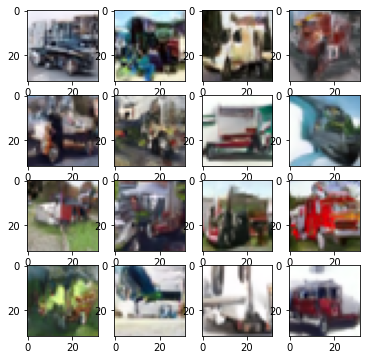

In [25]:
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(sampled_img[i].cpu().permute((1,2,0)))